In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [16]:
dr_train = '/kaggle/input/playground-series-s4e7/train.csv'
dr_test = '/kaggle/input/playground-series-s4e7/test.csv'

In [4]:
train = pd.read_csv(dr_train)
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [5]:
test = pd.read_csv(dr_test)
test

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148
...,...,...,...,...,...,...,...,...,...,...,...
7669861,19174659,Male,57,1,28.0,0,1-2 Year,Yes,51661.0,124.0,109
7669862,19174660,Male,28,1,50.0,1,< 1 Year,No,25651.0,152.0,184
7669863,19174661,Male,47,1,33.0,1,1-2 Year,No,2630.0,138.0,63
7669864,19174662,Male,30,1,28.0,0,< 1 Year,Yes,38866.0,124.0,119


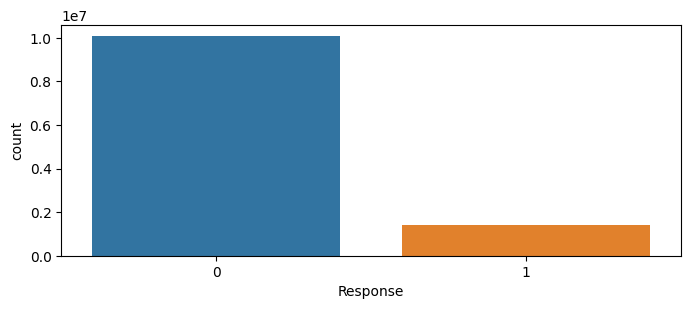

In [6]:
plt.figure(figsize=(8,3))
sns.countplot(x='Response', data=train)
plt.show()

0으로 응답한 비율이 훨씬 많음 -> 불균형

### id column 제거

In [7]:
ID = test['id']
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

### 데이터 분석

In [8]:
train.describe().T.round(2).style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
Age,11504798.000000,38.380000,14.990000,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,11504798.000000,1.000000,0.040000,0.000000,1.000000,1.000000,1.000000,1.000000
Region_Code,11504798.000000,26.420000,12.990000,0.000000,15.000000,28.000000,35.000000,52.000000
Previously_Insured,11504798.000000,0.460000,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Annual_Premium,11504798.000000,30461.370000,16454.750000,2630.000000,25277.000000,31824.000000,39451.000000,540165.000000
Policy_Sales_Channel,11504798.000000,112.430000,54.040000,1.000000,29.000000,151.000000,152.000000,163.000000
Vintage,11504798.000000,163.900000,79.980000,10.000000,99.000000,166.000000,232.000000,299.000000
Response,11504798.000000,0.120000,0.330000,0.000000,0.000000,0.000000,0.000000,1.000000


 Response: 불균형 분포를 보이기 때문에 언더 샘플링 시도해보기 <br>
 Age: 평균이 38.4, 표준편차가 15로 적절히 퍼져있음. 범위는 20 ~ 85<br>
 Previously_Insured: 절반의 사람들이 이 전에 보험을 가입함

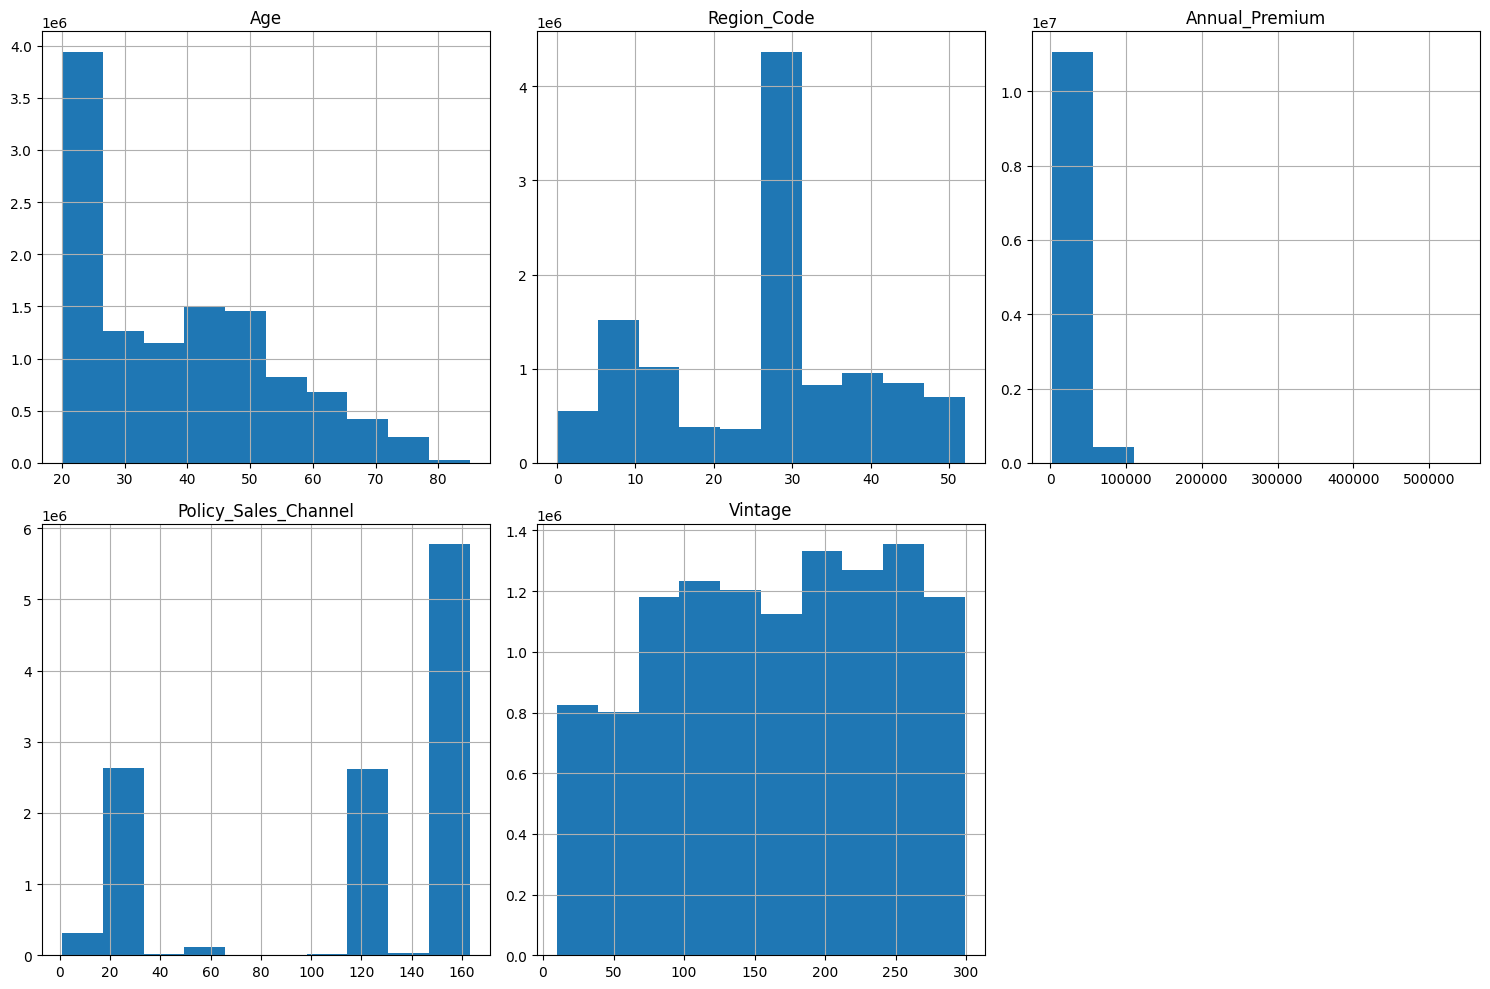

In [9]:
numeric_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

train[numeric_columns].hist(bins=10, figsize=(15, 10), layout=(2, 3))

plt.tight_layout()
plt.show()

### 전처리 

In [18]:
#수치형 변수: Region_Code, Annual_Premium, Policy_Sales_Channel, Vintage -> normalize
scaler = StandardScaler()
train[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']] = scaler.fit_transform(train[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']])
test[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']] = scaler.transform(test[['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']])

In [20]:
'''
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['Gender'= le.fit_transform(test['Gender'])
train['Vehicle_Age'] = le.fit_transform(train['Gender'])
test['Vehicle_Age'] = le.fit_transform(test['Vehicle_Age'])
train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
test['Vehicle_Damage'] = le.fit_transform(test['Vehicle_Damage'])
'''
# 범주형 변수 원핫 인코딩
category_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

train_category = pd.get_dummies(train, columns=category_columns, drop_first=True, dtype=int)
test_category = pd.get_dummies(test, columns=category_columns, drop_first=True, dtype=int)

In [21]:
train_sampled = train_category.sample(frac=0.01, random_state = 42)

In [30]:
X = train_sampled.drop(['Response'], axis=1)
y = train_sampled['Response']

In [51]:
# 언더 샘플링 -> 성능이 더 떨어짐,,
print(f'Original class distribution: {Counter(y)}')
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
print(f'Resampled class distribution: {Counter(y_res)}')

Original class distribution: Counter({0: 100907, 1: 14141})
Resampled class distribution: Counter({0: 14141, 1: 14141})


In [52]:
# 오버 샘플랑 -> 성능 높아짐..?
print(f'Original class distribution: {Counter(y)}')
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)
print(f'Resampled class distribution: {Counter(y_over)}')

Original class distribution: Counter({0: 100907, 1: 14141})
Resampled class distribution: Counter({0: 100907, 1: 100907})


### 모델링

In [22]:
def modeling(model, X, y):
    
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # k-fold 교차 검증 설정
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state =42)
    train_scores = []
    valid_scores = []
    
    # 교차 검증 반복
    for fold, (train_index, valid_index) in enumerate(tqdm(skf.split(X_train, y_train), total=skf.get_n_splits(), desc="Folds"), 1):
        X_skf_train, X_skf_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_skf_train, y_skf_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

        # 데이터 스케일링 - minmax
        scaler = MinMaxScaler()
        X_skf_train = scaler.fit_transform(X_skf_train)
        X_skf_valid = scaler.transform(X_skf_valid)

        model.fit(X_skf_train, y_skf_train)

        train_preds = model.predict_proba(X_skf_train)[:, 1]
        train_auc = roc_auc_score(y_skf_train, train_preds)
        train_scores.append(train_auc)

        valid_preds = model.predict_proba(X_skf_valid)[:, 1]
        valid_auc = roc_auc_score(y_skf_valid, valid_preds)
        valid_scores.append(valid_auc)

        print(f'Fold {fold}: Train ROC AUC: {train_auc:.4f}, Validation ROC AUC: {valid_auc:.4f}')

    print(f'Average Train ROC AUC: {sum(train_scores)/len(train_scores):.4f}')
    print(f'Average Validation ROC AUC: {sum(valid_scores)/len(valid_scores):.4f}')

    X_test_scaled = scaler.transform(X_test)
    test_preds = model.predict_proba(X_test_scaled)[:, 1]
    test_auc = roc_auc_score(y_test, test_preds)
    print(f'Test ROC AUC: {test_auc:.4f}')


    return train_scores, valid_scores, test_auc
    

### 학습

In [53]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("\nXGBoost:")
xgb_train_scores, xgb_valid_scores, xgb_test_auc = modeling(xgb_model, X, y)

print("\nundersampling XGBoost:")
xgb_train_scores, xgb_valid_scores, xgb_test_auc = modeling(xgb_model, X_under, y_under)

print("\noversampling XGBoost:")
xgb_train_scores, xgb_valid_scores, xgb_test_auc = modeling(xgb_model, X_over, y_over)


XGBoost:


Folds:  20%|██        | 1/5 [00:01<00:07,  1.88s/it]

Fold 1: Train ROC AUC: 0.9225, Validation ROC AUC: 0.8644


Folds:  40%|████      | 2/5 [00:03<00:05,  1.78s/it]

Fold 2: Train ROC AUC: 0.9213, Validation ROC AUC: 0.8609


Folds:  60%|██████    | 3/5 [00:05<00:03,  1.68s/it]

Fold 3: Train ROC AUC: 0.9200, Validation ROC AUC: 0.8674


Folds:  80%|████████  | 4/5 [00:06<00:01,  1.74s/it]

Fold 4: Train ROC AUC: 0.9226, Validation ROC AUC: 0.8582


Folds: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


Fold 5: Train ROC AUC: 0.9237, Validation ROC AUC: 0.8564
Average Train ROC AUC: 0.9220
Average Validation ROC AUC: 0.8615
Test ROC AUC: 0.8615

undersampling XGBoost:


Folds:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Fold 1: Train ROC AUC: 0.9465, Validation ROC AUC: 0.8495


Folds:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Fold 2: Train ROC AUC: 0.9470, Validation ROC AUC: 0.8456


Folds:  60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

Fold 3: Train ROC AUC: 0.9490, Validation ROC AUC: 0.8455


Folds:  80%|████████  | 4/5 [00:01<00:00,  2.09it/s]

Fold 4: Train ROC AUC: 0.9476, Validation ROC AUC: 0.8537


Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Fold 5: Train ROC AUC: 0.9490, Validation ROC AUC: 0.8541
Average Train ROC AUC: 0.9478
Average Validation ROC AUC: 0.8497
Test ROC AUC: 0.8497

oversampling XGBoost:


Folds:  20%|██        | 1/5 [00:02<00:11,  2.99s/it]

Fold 1: Train ROC AUC: 0.9503, Validation ROC AUC: 0.9374


Folds:  40%|████      | 2/5 [00:05<00:08,  2.79s/it]

Fold 2: Train ROC AUC: 0.9508, Validation ROC AUC: 0.9377


Folds:  60%|██████    | 3/5 [00:08<00:05,  2.72s/it]

Fold 3: Train ROC AUC: 0.9513, Validation ROC AUC: 0.9404


Folds:  80%|████████  | 4/5 [00:10<00:02,  2.72s/it]

Fold 4: Train ROC AUC: 0.9503, Validation ROC AUC: 0.9412


Folds: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

Fold 5: Train ROC AUC: 0.9524, Validation ROC AUC: 0.9418
Average Train ROC AUC: 0.9510
Average Validation ROC AUC: 0.9397
Test ROC AUC: 0.9420


In [54]:
# CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=42)
print("\nCatBoost:")
cat_train_scores, cat_valid_scores, cat_test_auc = modeling(cat_model, X, y)
print("\nundersampling CatBoost:")
cat_train_scores, cat_valid_scores, cat_test_auc = modeling(cat_model, X_under, y_under)
print("\oversampling CatBoost:")
cat_train_scores, cat_valid_scores, cat_test_auc = modeling(cat_model, X_over, y_over)



CatBoost:


Folds:  20%|██        | 1/5 [00:13<00:54, 13.72s/it]

Fold 1: Train ROC AUC: 0.9078, Validation ROC AUC: 0.8676


Folds:  40%|████      | 2/5 [00:28<00:42, 14.16s/it]

Fold 2: Train ROC AUC: 0.9081, Validation ROC AUC: 0.8620


Folds:  60%|██████    | 3/5 [00:42<00:28, 14.00s/it]

Fold 3: Train ROC AUC: 0.9060, Validation ROC AUC: 0.8711


Folds:  80%|████████  | 4/5 [00:56<00:14, 14.06s/it]

Fold 4: Train ROC AUC: 0.9084, Validation ROC AUC: 0.8605


Folds: 100%|██████████| 5/5 [01:09<00:00, 13.95s/it]


Fold 5: Train ROC AUC: 0.9090, Validation ROC AUC: 0.8591
Average Train ROC AUC: 0.9079
Average Validation ROC AUC: 0.8641
Test ROC AUC: 0.8669

undersampling CatBoost:


Folds:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]

Fold 1: Train ROC AUC: 0.9180, Validation ROC AUC: 0.8544


Folds:  40%|████      | 2/5 [00:11<00:17,  5.88s/it]

Fold 2: Train ROC AUC: 0.9178, Validation ROC AUC: 0.8533


Folds:  60%|██████    | 3/5 [00:17<00:11,  5.90s/it]

Fold 3: Train ROC AUC: 0.9199, Validation ROC AUC: 0.8554


Folds:  80%|████████  | 4/5 [00:23<00:05,  5.88s/it]

Fold 4: Train ROC AUC: 0.9178, Validation ROC AUC: 0.8591


Folds: 100%|██████████| 5/5 [00:29<00:00,  5.99s/it]


Fold 5: Train ROC AUC: 0.9186, Validation ROC AUC: 0.8575
Average Train ROC AUC: 0.9184
Average Validation ROC AUC: 0.8559
Test ROC AUC: 0.8542
\oversampling CatBoost:


Folds:  20%|██        | 1/5 [00:19<01:18, 19.54s/it]

Fold 1: Train ROC AUC: 0.9680, Validation ROC AUC: 0.9616


Folds:  40%|████      | 2/5 [00:39<01:00, 20.08s/it]

Fold 2: Train ROC AUC: 0.9678, Validation ROC AUC: 0.9614


Folds:  60%|██████    | 3/5 [00:59<00:40, 20.00s/it]

Fold 3: Train ROC AUC: 0.9678, Validation ROC AUC: 0.9621


Folds:  80%|████████  | 4/5 [01:19<00:19, 19.87s/it]

Fold 4: Train ROC AUC: 0.9677, Validation ROC AUC: 0.9631


Folds: 100%|██████████| 5/5 [01:39<00:00, 19.97s/it]

Fold 5: Train ROC AUC: 0.9678, Validation ROC AUC: 0.9634
Average Train ROC AUC: 0.9678
Average Validation ROC AUC: 0.9623
Test ROC AUC: 0.9630


In [55]:
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
print("\nlightgbm:")
lgbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X, y)
print("\nundersampling lightgbm:")
lgbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X_under, y_under)
print("\noversampling lightgbm:")
lgbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X_over, y_over)


lightgbm:


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start training from score -1.964636


Folds:  20%|██        | 1/5 [00:01<00:06,  1.63s/it]

Fold 1: Train ROC AUC: 0.8861, Validation ROC AUC: 0.8642
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start training from score -1.964636


Folds:  40%|████      | 2/5 [00:03<00:04,  1.60s/it]

Fold 2: Train ROC AUC: 0.8926, Validation ROC AUC: 0.8612
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start training from score -1.964636


Folds:  60%|██████    | 3/5 [00:04<00:03,  1.61s/it]

Fold 3: Train ROC AUC: 0.8926, Validation ROC AUC: 0.8696
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 73631, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122978 -> initscore=-1.964526
[LightGBM] [Info] Start training from score -1.964526


Folds:  80%|████████  | 4/5 [00:06<00:01,  1.59s/it]

Fold 4: Train ROC AUC: 0.8910, Validation ROC AUC: 0.8598
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 73631, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122978 -> initscore=-1.964526
[LightGBM] [Info] Start training from score -1.964526


Folds: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Fold 5: Train ROC AUC: 0.8926, Validation ROC AUC: 0.8607
Average Train ROC AUC: 0.8910
Average Validation ROC AUC: 0.8631
Test ROC AUC: 0.8667

undersampling lightgbm:


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9046, number of negative: 9054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 18100, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499779 -> initscore=-0.000884
[LightGBM] [Info] Start training from score -0.000884


Folds:  20%|██        | 1/5 [00:00<00:01,  2.09it/s]

Fold 1: Train ROC AUC: 0.9074, Validation ROC AUC: 0.8547
[LightGBM] [Info] Number of positive: 9046, number of negative: 9054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 18100, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499779 -> initscore=-0.000884
[LightGBM] [Info] Start training from score -0.000884


Folds:  40%|████      | 2/5 [00:00<00:01,  2.15it/s]

Fold 2: Train ROC AUC: 0.9090, Validation ROC AUC: 0.8548
[LightGBM] [Info] Number of positive: 9046, number of negative: 9054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 18100, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499779 -> initscore=-0.000884
[LightGBM] [Info] Start training from score -0.000884


Folds:  60%|██████    | 3/5 [00:01<00:00,  2.18it/s]

Fold 3: Train ROC AUC: 0.9096, Validation ROC AUC: 0.8557
[LightGBM] [Info] Number of positive: 9045, number of negative: 9055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 18100, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499724 -> initscore=-0.001105
[LightGBM] [Info] Start training from score -0.001105


Folds:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Fold 4: Train ROC AUC: 0.9080, Validation ROC AUC: 0.8559
[LightGBM] [Info] Number of positive: 9045, number of negative: 9055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 18100, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499724 -> initscore=-0.001105
[LightGBM] [Info] Start training from score -0.001105


Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Fold 5: Train ROC AUC: 0.9080, Validation ROC AUC: 0.8562
Average Train ROC AUC: 0.9084
Average Validation ROC AUC: 0.8555
Test ROC AUC: 0.8559

oversampling lightgbm:


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 64452, number of negative: 64708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1093
[LightGBM] [Info] Number of data points in the train set: 129160, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499009 -> initscore=-0.003964
[LightGBM] [Info] Start training from score -0.003964


Folds:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

Fold 1: Train ROC AUC: 0.9541, Validation ROC AUC: 0.9510
[LightGBM] [Info] Number of positive: 64452, number of negative: 64709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 129161, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499005 -> initscore=-0.003980
[LightGBM] [Info] Start training from score -0.003980


Folds:  40%|████      | 2/5 [00:06<00:10,  3.41s/it]

Fold 2: Train ROC AUC: 0.9543, Validation ROC AUC: 0.9505
[LightGBM] [Info] Number of positive: 64452, number of negative: 64709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 129161, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499005 -> initscore=-0.003980
[LightGBM] [Info] Start training from score -0.003980


Folds:  60%|██████    | 3/5 [00:10<00:06,  3.36s/it]

Fold 3: Train ROC AUC: 0.9548, Validation ROC AUC: 0.9523
[LightGBM] [Info] Number of positive: 64452, number of negative: 64709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 129161, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499005 -> initscore=-0.003980
[LightGBM] [Info] Start training from score -0.003980


Folds:  80%|████████  | 4/5 [00:13<00:03,  3.39s/it]

Fold 4: Train ROC AUC: 0.9533, Validation ROC AUC: 0.9522
[LightGBM] [Info] Number of positive: 64452, number of negative: 64709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 129161, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499005 -> initscore=-0.003980
[LightGBM] [Info] Start training from score -0.003980


Folds: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

Fold 5: Train ROC AUC: 0.9546, Validation ROC AUC: 0.9544
Average Train ROC AUC: 0.9542
Average Validation ROC AUC: 0.9521


Test ROC AUC: 0.9535


### xgboost, catboost, lgbm 앙상블 모델
-시도해보기